# Compare accuracies

In [1]:
import os
import fnmatch
import pandas as pd
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
from utils import isolate_int, flatten_2D_list
from data_extractor import output_vars_v4
import numpy as np
from copy import deepcopy

In [2]:
path = 'saved_models/'
model_prefixes = ['TEST9_global_v4_all_channels_depth_', 'TEST9_sel1_depth_']
labels = ['All features', 'Selection of features']
val = pd.read_pickle('extracted_data/TEST9_global_v4_val')

In [3]:
vars_list = []

with open('saved_results/features&label_all_v4', 'rb') as file:
        vars_all_v4 = pickle.load(file)
vars_list.append(vars_all_v4)

with open('saved_results/features&label_sel1', 'rb') as file:
        vars_sel1 = pickle.load(file)
vars_list.append(vars_sel1)

In [4]:
print(vars_sel1)

['mt_1MET', 'HNL_CM_mass_with_MET_1', 'mt_12', 'mass_12', 'pt_2', 'mass_123', 'HNL_CM_mass_2', 'mt_1(3MET)', 'mt_23', 'HNL_CM_mass_1', 'HNL_CM_mass_with_MET_2', 'mt_3MET', 'pt_MET', 'mass_23', 'mt_2(1MET)', 'mt_1(2MET)', 'mt_MET(23)', 'Mt_tot', 'mt_MET(13)', 'mass_hyp', 'pt_123', 'pt_1', 'mt_2MET', 'mt_3(2MET)', 'mt_1(23)', 'mt_2(13)', 'mass_13', 'mt_13', 'channel', 'signal_label']


In [5]:
model_names_list = []
depths_list = []
for model_prefix in model_prefixes:
    model_names = fnmatch.filter(os.listdir(path), model_prefix+'*')
    model_names_list.append(model_names)
    depths = []
    for name in model_names:
        depth = isolate_int(name, separators='_')[0]
        depths.append(depth)
    depths_list.append(depths)

In [6]:
def eval_accuracies(model_names, val, selected_vars):
    x_val = val[selected_vars]
    label_val = x_val.pop('signal_label').astype(float)
    weighted_accs = []
    for model_name in model_names:
        model = tf.keras.models.load_model(path+model_name)
        results = model.evaluate(x_val, label_val, sample_weight=val['genWeight'])
        weighted_accs.append(results[-1])
    return weighted_accs


In [7]:
weighted_accs_list = []
for i, model_names in enumerate(model_names_list):
    weighted_accs = eval_accuracies(model_names, val, vars_list[i])
    weighted_accs_list.append(weighted_accs)

2023-05-27 14:46:05.588797: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-27 14:46:06.557796: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6673 MB memory:  -> device: 0, name: Quadro RTX 4000, pci bus id: 0000:17:00.0, compute capability: 7.5
2023-05-27 14:46:06.558531: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6653 MB memory:  -> device: 1, name: Quadro RTX 4000, pci bus id: 0000:65:00.0, compute capability: 7.5


6295/6295 [==============================] - 24s 4ms/step - loss: 0.1582 - accuracy: 0.6425 - weighted_accuracy: 0.9407


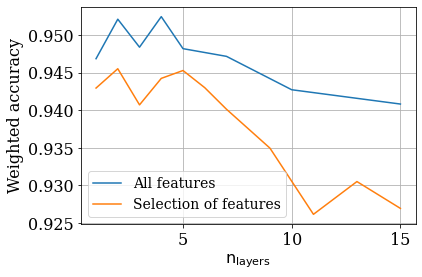

In [21]:
for i in range(len(depths_list)):
    x, y = zip(*sorted(list(zip(depths_list[i], weighted_accs_list[i])), key=lambda x: x[0]))
    plt.plot(x, y,label=labels[i])
plt.xlabel(r'$\mathrm{n_{layers}}$')
plt.ylabel('Weighted accuracy')
plt.legend()
plt.grid()

# Compare poisson significance estimator

In [23]:
from metrics import poisson_significance
import pandas as pd
from utils import plot_hist, isolate_int
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import fnmatch

In [21]:
path = 'saved_models/'
model_prefixes = ['TEST9_global_v4_all_channels_depth_', 'TEST9_sel1_depth_']
labels = ['All features', 'Selection of features']
val = pd.read_pickle('extracted_data/TEST9_global_v4_val')
vars_list = []

with open('saved_results/features&label_all_v4', 'rb') as file:
        vars_all_v4 = pickle.load(file)
vars_list.append(vars_all_v4)

with open('saved_results/features&label_sel1', 'rb') as file:
        vars_sel1 = pickle.load(file)
vars_list.append(vars_sel1)

In [24]:
model_names_list = []
depths_list = []
for model_prefix in model_prefixes:
    model_names = fnmatch.filter(os.listdir(path), model_prefix+'*')
    model_names_list.append(model_names)
    depths = []
    for name in model_names:
        depth = isolate_int(name, separators='_')[0]
        depths.append(depth)
    depths_list.append(depths)

In [ ]:
for i, model_names in enumerate(model_names_list):
    